# Collaborators:

- Niels Savvides
- Matisse Callewaert
- Thibaud Despriet
- Ilkay Yuksel

# Lab III: Image Formation and Transformations

## Define Imports

In [13]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob
from termcolor import colored

## 1: The pinhole camera model

### Exercise 1:

**Write a simple camera simulator that projects a 3D wireframe model to image coordinates.**


#### Question 1:

**What is the camera matrix for a 1080p camera with a horizontal field of view of 90 degrees?**

$$ K = \begin{bmatrix} f_x & 0   & c_x \\ 0   & f_y & c_y \\ 0   & 0   & 1 \end{bmatrix} $$

$$ f_x = \frac{Resolution_{horizontal}}{2 * \tan{\frac{POV_{horizontal}}{2}}} $$

$$ f_x = \frac{1920}{2 * \tan{\frac{90}{2}}} = 960 $$

Since the pixels are squares, 
$$ f_y = f_x $$

$$ c_x = 1920 / 2 = 960 $$ 
and 
$$ c_y = 1080 / 2 = 540 $$

The camera matrix for a 1080p camera is then:

$$ K = \begin{bmatrix} 960 & 0   & 960 \\ 0   & 960 & 540 \\ 0   & 0   & 1 \end{bmatrix} $$

### Assignment 1

**Create a virtual 3D cube with a side of 1 meter, defined as an 8x3 matrix containing the 3D coordinates
of the vertices of the cube relative to the camera (you can choose the exact position, picture the situation
in your head or make a quick freehand diagram), and a 12x2 array of edges described by pairs of vertex
indices that need to be connected by lines;**

**Project the 3D vertex coordinates to 2D image coordinates using your camera matrix from Question
1, and visualize the result by drawing the vertices and edges on an empty 1080p image. Pay attention
to the dimensions of your matrices, transpose as necessary and round the image coordinates to integer
pixels.**

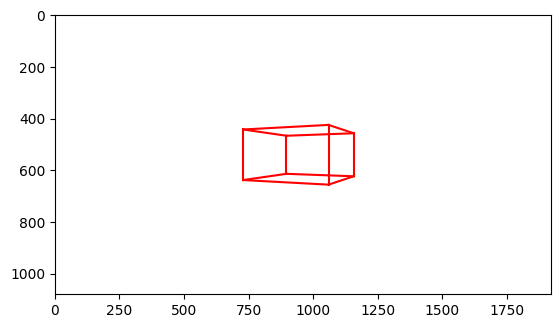

In [14]:
# Cube vertices
cube_vertices = np.float32([
    [0.5, 0.5, -0.5],
    [-0.5, 0.5, -0.5],
    [-0.5, -0.5, -0.5],
    [0.5, -0.5, -0.5],
    [0.5, 0.5, 0.5],
    [-0.5, 0.5, 0.5],
    [-0.5, -0.5, 0.5],
    [0.5, -0.5, 0.5]
])

# Cube edges
cube_edges = [
    (0, 1), (1, 2), (2, 3), (3, 0),
    (4, 5), (5, 6), (6, 7), (7, 4),
    (0, 4), (1, 5), (2, 6), (3, 7)
]

# Camera matrix
fov = 90
aspect_ratio = 1920 / 1080
focal_length = (1920 / 2) / np.tan(fov * np.pi / 360)
cx, cy = 1920 / 2, 1080 / 2

camera_matrix = np.array([
    [focal_length, 0, cx],
    [0, focal_length / aspect_ratio, cy],
    [0, 0, 1]
])

# Project the cube vertices onto a 2D image
theta = np.radians(25)  # Rotation around y-axis
cos, sin = np.cos(theta), np.sin(theta)
Ry = np.array([[cos, 0, sin],
               [0, 1, 0],
               [-sin, 0, cos]])

phi = np.radians(90)  # Rotation around x-axis
cos, sin = np.cos(phi), np.sin(phi)
Rx = np.array([[1, 0, 0],
               [0, cos, -sin],
               [0, sin, cos]])

R = Ry @ Rx  # Combine
T = np.array([0, 0, 3]).reshape(3, 1)  # Translate

fig, ax = plt.subplots()
ax.set_aspect('equal')
ax.set_xlim(0, 1920)
ax.set_ylim(0, 1080)
ax.invert_yaxis()

for edge in cube_edges:
    pt1_3d = np.append(cube_vertices[edge[0]], 1)
    pt2_3d = np.append(cube_vertices[edge[1]], 1)
    
    # Rotation and translation
    pt1_3d_transformed = R @ pt1_3d[:3] + T[:, 0]
    pt2_3d_transformed = R @ pt2_3d[:3] + T[:, 0]
    
    # 3D points to 2D
    pt1_2d = camera_matrix @ pt1_3d_transformed
    pt2_2d = camera_matrix @ pt2_3d_transformed
    
    # Homogeneous to cartesian
    pt1_2d /= pt1_2d[2]
    pt2_2d /= pt2_2d[2]
    
    ax.plot([pt1_2d[0], pt2_2d[0]], [pt1_2d[1], pt2_2d[1]], color='red')

plt.show()

#### Question 2:

**If you double the focal distance, what happens to the picture?**

>Doubling the focal distance in a pinhole camera model will cause the projected image to appear larger. This is because the increased focal length magnifies the image on the image plane. However, objects will also seem to be "flatter" and the perspective effect will be less visible.

## 2: Camera calibration

#### Question 3:

**Why are there only even powers in this polynomial in $r$?**

> The reason for using only even powers in the radial distortion correction polynomial ($1 + k_1 r^2 + k_2 r^4$) is to capture the symmetric nature of radial distortion.
> 
>Using odd powers in the polynomial would introduce asymmetric distortion correction terms, which may not accurately represent the typical behavior of radial distortion. 

### Exercise 2:

**Calibrate a camera based on checkerboard pattern views.**

### Assignment 2 

**Determine the intrinsic matrix and distortion parameters of the gopro camera used to shoot
the calibration sequence you find on Ufora as calibration frames.zip. Print the matrix and coefficients in
your report.**

In [15]:
# First we examine the checkerboard size manually by looking at the inner corners of the board.
checkerboard_size = (6, 10)

# Init our checkerboard in 3 dimensions
checkerboard_world_space = np.zeros((checkerboard_size[0]*checkerboard_size[1],3), np.float32)
checkerboard_world_space[:,:2] = np.mgrid[0:checkerboard_size[0],0:checkerboard_size[1]].T.reshape(-1,2)

objpoints = [] # 3D points in real world space
imgpoints = [] # 2D points in image plane

for file in glob.glob('calibration_frames/*.png'):
    img = cv2.imread(file)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chess board corners, thank you cv2 for providing such a useful function
    ret, corners = cv2.findChessboardCorners(gray, checkerboard_size, None)

    if ret == True:
        objpoints.append(checkerboard_world_space)
        imgpoints.append(corners)

# Calibrate camera
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

print(colored("Camera matrix:\n\n", "green"), mtx, "\n")
print(colored("Distortion coefficients:\n\n", "green"), dist)

Camera matrix:

 [[752.08935724   0.         638.6017353 ]
 [  0.         749.28786047 377.27104364]
 [  0.           0.           1.        ]] 

Distortion coefficients:

 [[-0.31738923  0.1349355  -0.01077208  0.00326031 -0.03234886]]


#### Assignment 3:

**Do the calibration procedure for different random subsets of 20 frames. Print the standard
deviation across these calibration experiments on each of the parameters**

In [16]:
def calibrate_camera_with_subsets(subset_size=20, n_experiments=10):
    files = glob.glob('calibration_frames/*.png')
    np.random.seed(42)
    
    checkerboard_size = (6, 10) # See previous cell (this was done visually)
    
    camera_matrices = []
    distortion_coefficients = []
    
    best_mtx = None
    best_dist = None
    lowest_error = np.inf
    
    for _ in range(n_experiments):
        random_selected_files = np.random.choice(files, size=subset_size, replace=False)
        
        objpoints = [] # 3D points in real world space
        imgpoints = [] # 2D points in image plane
        
        checkerboard_world_space = np.zeros((checkerboard_size[0]*checkerboard_size[1], 3), np.float32)
        checkerboard_world_space[:, :2] = np.mgrid[0:checkerboard_size[0], 0:checkerboard_size[1]].T.reshape(-1, 2)
        
        for file in random_selected_files:
            img = cv2.imread(file)
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            
            # Find the chess board corners
            ret, corners = cv2.findChessboardCorners(gray, checkerboard_size, None)
            
            # If found, add object points, image points
            if ret == True:
                objpoints.append(checkerboard_world_space)
                imgpoints.append(corners)
        
        # Calibrate camera
        ret, mtx, dist, _, _ = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
        
        # Store calibration parameters
        if ret:
            camera_matrices.append(mtx)
            distortion_coefficients.append(dist)
            
            # Calculate re-projection error
            mean_error = 0
            for i in range(len(objpoints)):
                imgpoints2, _ = cv2.projectPoints(objpoints[i], rvecs[i], tvecs[i], mtx, dist)
                error = cv2.norm(imgpoints[i], imgpoints2, cv2.NORM_L2)/len(imgpoints2)
                mean_error += error
            
            if(mean_error < lowest_error):
                lowest_error = mean_error
                best_mtx = mtx
                best_dist = dist
    
    # Numpy is more efficient...
    camera_matrices = np.array(camera_matrices)
    distortion_coefficients = np.array(distortion_coefficients)
    
    # Compute standard deviation
    camera_matrices_std = np.std(camera_matrices, axis=0)
    distortion_coefficients_std = np.std(distortion_coefficients, axis=0)
    
    return best_mtx, best_dist, camera_matrices_std, distortion_coefficients_std

In [17]:
_, _, camera_matrices_std, distortion_coefficients_std = calibrate_camera_with_subsets()
print(colored("Standard deviation of camera matrices:\n", 'green'), camera_matrices_std)
print(colored("\nStandard deviation of distortion coefficients:\n", 'green'), distortion_coefficients_std)

Standard deviation of camera matrices:
 [[202.41738495   0.          12.83352261]
 [  0.         176.36212587  20.95779972]
 [  0.           0.           0.        ]]

Standard deviation of distortion coefficients:
 [[0.07156113 0.1245788  0.012312   0.01110379 0.05607005]]


#### Assignment 4:

**Use your best calibration result to undistort one of the frames from the sequence. Lines
that are straight in reality should be straight in your rectified image now.**

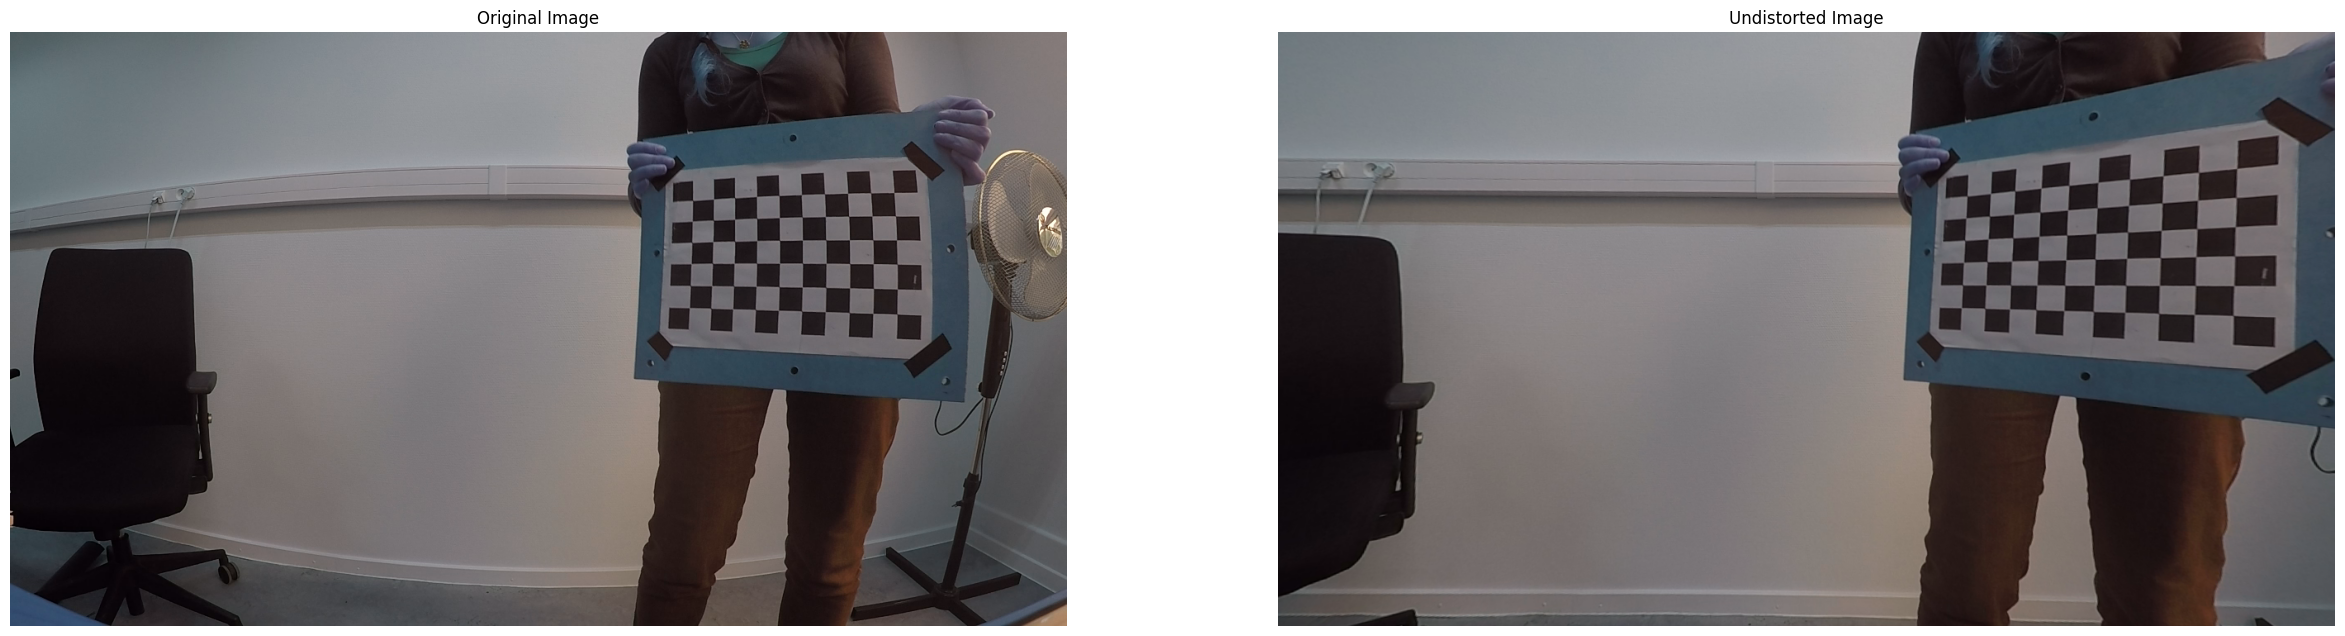

In [18]:
# Calculate best matrix && distortion coefficients (lowest error)
best_mtx, best_dist, _, _ = calibrate_camera_with_subsets()

# Pick a file from image set
img = cv2.imread('calibration_frames/img_0058.png')

# Undistort image
undistorted_img = cv2.undistort(img, best_mtx, best_dist, None, best_mtx)

fig, axs = plt.subplots(1, 2, figsize=(30, 20))
axs[0].imshow(img)
axs[0].set_title('Original Image')
axs[0].axis('off')

axs[1].imshow(undistorted_img)
axs[1].set_title('Undistorted Image')
axs[1].axis('off')

plt.show()

**Tip: there is a camera calibration example in the opencv documentation.**

## **3: Geometric Transformations**

### Exercise 3:

**Write a program that applies a horizontal shear transform to an image. The transformation matrix to shear
horizontally has this form:**

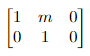

where $m$ is the shear factor. Note the dimensions: this is an image-to-image transform, but it has 3
columns, meaning it applies to homogeneous coordinates.

#### Assignment 5:

**Shear shadow.png so that the photographer’s shadow becomes vertical. Size your target
image so that it will be large enough to accommodate the sheared image, and make sure that all parts of the original image are visible. You can add translation by placing pixel offsets in the third column.**

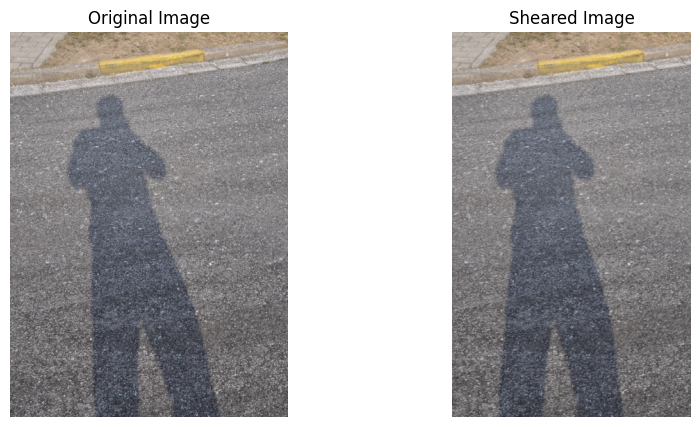

In [19]:
def calculate_shear_factor(image):
    # Assuming the shadow starts from the bottom-left corner of the image
    # and extends upwards, we find the angle between the shadow and the vertical direction.
    angle_rad = -0.1
    shear_factor = np.tan(angle_rad)
    return shear_factor

def shear_transform(image, shear_factor):
    if image is None:
        raise ValueError("Error loading image.")

    rows, cols = image.shape[0], image.shape[1]
    
    # Define the transformation matrix
    M = np.array([[1, shear_factor, 0],
                  [0, 1, 0]])

    # Apply the transformation using warpAffine function
    sheared_image = cv2.warpAffine(image, M, (int(cols + shear_factor*rows), rows))
    
    return sheared_image

image = cv2.imread('source_images/shadow.png')

# Calculate the shear factor
shear_factor = calculate_shear_factor(image)

# Apply the shear transform
sheared_image = shear_transform(image, shear_factor)

# Display the original and sheared images using matplotlib
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Sheared Image')
plt.imshow(cv2.cvtColor(sheared_image, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.show()

### Exercise 4:

**Write a program that applies a perspective transform to obtain a perpendicular view on the ground plane,
also called a bird’s eye view. Unlike a rotation, scaling or shear transform, a perspective transform is not
trivial to define manually. Usually, you will determine a perspective transform by solving for it: you specify
a set of source coordinates and target coordinates for a set of points, and the transformation that maps one
onto the other is determined by solving the following system:**

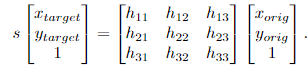

**This system has 8 degrees of freedom (it is only defined up to a scale factor, which does not matter in
homogeneous coordinates), so you need source and target coordinates for at least 4 points (resulting in 4
equations in x and 4 equations in y)**

#### Assignment 6:

**Apply a perspective transform to shadow box.png so that the photographer in not only
stands vertically, but is also proportionally correct. In your program you click on the 4 corners of the tetragon
that you want to transform into a rectangle, after which the right perspective transformation is searched
for and executed. In order to make an image display window clickable, you have to set a mouse callback
function that is called anytime your mouse pointer interacts in some way with the window.**

In [29]:
points = []
clicked = False

def mouse_callback(event, x, y, flags, _):
    global points, clicked

    if event == cv2.EVENT_LBUTTONDOWN:
        print("Point", len(points) + 1, ":", x, y)
        points.append((x, y))
        cv2.circle(img, (x, y), 5, (0, 255, 0), -1)

        if len(points) == 4:
            clicked = True

img = cv2.imread('source_images/shadow_box.png')

cv2.namedWindow('Select 4 points')
cv2.setMouseCallback('Select 4 points', mouse_callback)

while True:
    cv2.imshow('Select 4 points', img)

    if clicked:
        break

    if cv2.waitKey(1)==27: # Note: Press Escape to stop program
        break

cv2.destroyAllWindows()

# Define dimensions
width, height = img.shape[1], img.shape[0]

zoom_out_margin = 100 # Best correspondance to example of assignment

# Define the target rectangle for the bird's eye view with zoom out
target_points = np.array([
    [0 + zoom_out_margin, 0 + zoom_out_margin],
    [width - 1 - zoom_out_margin, 0 + zoom_out_margin],
    [width - 1 - zoom_out_margin, height - 1 - zoom_out_margin],
    [0 + zoom_out_margin, height - 1 - zoom_out_margin]
], dtype=np.float32)

# Convert the clicked points to NumPy array
src_points = np.array(points, dtype=np.float32)

ordered_points = np.zeros_like(src_points)
ordered_points[0] = src_points[np.argmin(np.sum(src_points, axis=1))]
ordered_points[1] = src_points[np.argmin(np.diff(src_points, axis=1))]
ordered_points[2] = src_points[np.argmax(np.sum(src_points, axis=1))]
ordered_points[3] = src_points[np.argmax(np.diff(src_points, axis=1))]

# Calculate perspective transform matrix
perspective_matrix = cv2.getPerspectiveTransform(ordered_points, target_points)

# Apply the perspective transform
bird_eye_view = cv2.warpPerspective(img, perspective_matrix, (width, height))

cv2.imshow('Original Image', img)
cv2.imshow('Bird\'s Eye View', bird_eye_view)
cv2.waitKey(0)
cv2.destroyAllWindows()

Point 1 : 109 89
Point 2 : 176 88
Point 3 : 296 540
Point 4 : 118 543


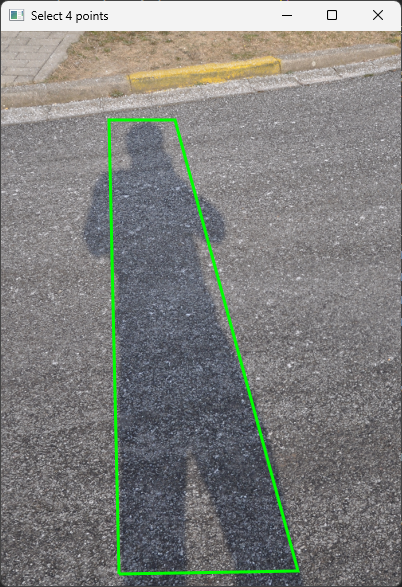

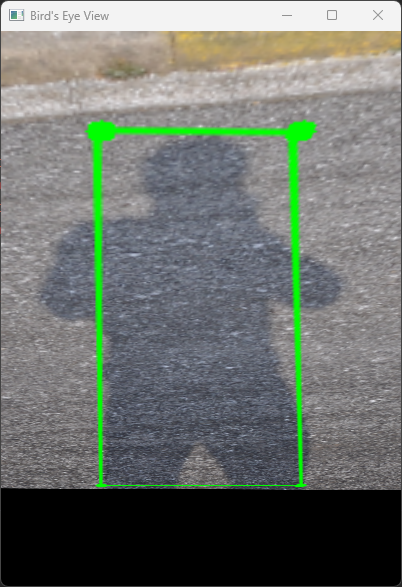

#### Question 4:
**If you were to specify more than 4 points, the system would be overdetermined. How can you
solve such an overdetermined system?**

> In an overdetermined system, there are more equations than unknowns. To solve such a system, you typically use a least-squares approach. In the context of a perspective transform, you would find a solution that minimizes the sum of the squared differences between the observed and calculated values.
>
> OpenCV provides the ``cv2.solve()`` function, which can be used to solve overdetermined systems using the least-squares method. In this case, you would create an augmented matrix where the last column contains the target coordinates and use cv2.solve() to find the perspective transform matrix.

#### Question 5:
**Can you find an opencv function that takes more than 4 points?**

> In OpenCV, the function ``cv2.findHomography(srcPoints, dstPoints)`` can be used to find a perspective transformation matrix (homography) for more than 4 points. The srcPoints and dstPoints are arrays of corresponding points in the source and destination images. The method parameter specifies the method to compute the homography, the following methods are possible:
>- **0** a regular method using all the points, i.e. the least squares method (default)
>- **Ransac** RANSAC-based robust method.
>- **LMedS** Least-Median of squares robust method.
>- **Rho** PROSAC-based robust method, introduced in [Bazargani15]. (weighted RANSAC modification, faster in the case of many outliers).